In [11]:
%pip install kmodes
%pip install yellowbrick
%pip install kneed

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [14]:
# Make imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import seaborn as sns
import pyclustertend
import random

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from kmodes.kprototypes import KPrototypes
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

import sys
import warnings
warnings.filterwarnings("ignore")

In [15]:
datos = pd.read_csv('Fuel_Consumption_2000-2022.csv')
print(datos.head())

descripcion = datos.describe()

#Revision de valores nulos
# Chequear si hay valores nulos
nan_columns = datos.columns[datos.isna().any()].tolist()
print(nan_columns)
print(datos[datos.isna().any(axis=1)])
print(len(datos[datos.isna().any(axis=1)]))
print(len(datos))

   YEAR   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS TRANSMISSION  \
0  2000  ACURA    1.6EL       COMPACT          1.6          4           A4   
1  2000  ACURA    1.6EL       COMPACT          1.6          4           M5   
2  2000  ACURA    3.2TL      MID-SIZE          3.2          6          AS5   
3  2000  ACURA    3.5RL      MID-SIZE          3.5          6           A4   
4  2000  ACURA  INTEGRA    SUBCOMPACT          1.8          4           A4   

  FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  COMB (mpg)  \
0    X               9.2             6.7              8.1          35   
1    X               8.5             6.5              7.6          37   
2    Z              12.2             7.4             10.0          28   
3    Z              13.4             9.2             11.5          25   
4    X              10.0             7.0              8.6          33   

   EMISSIONS  
0        186  
1        175  
2        230  
3        264  
4        198  
[]

¿Hacemos Clustering?

In [16]:
Y = np.array(datos[['MAKE']])

columns = datos.select_dtypes(include='number').columns.to_list()
columns.remove('YEAR')
# print(columns)
X = np.array(datos[columns])
X.shape

(22556, 7)

In [25]:
print(columns)

['ENGINE SIZE', 'CYLINDERS', 'FUEL CONSUMPTION', 'HWY (L/100 km)', 'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS']


In [17]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(X)

pyclustertend.hopkins(X,len(X))

0.0027196463588275545

In [5]:
pyclustertend.vat(X_scale)

KeyboardInterrupt: 

# Numero de grupos

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 7,211,358.345


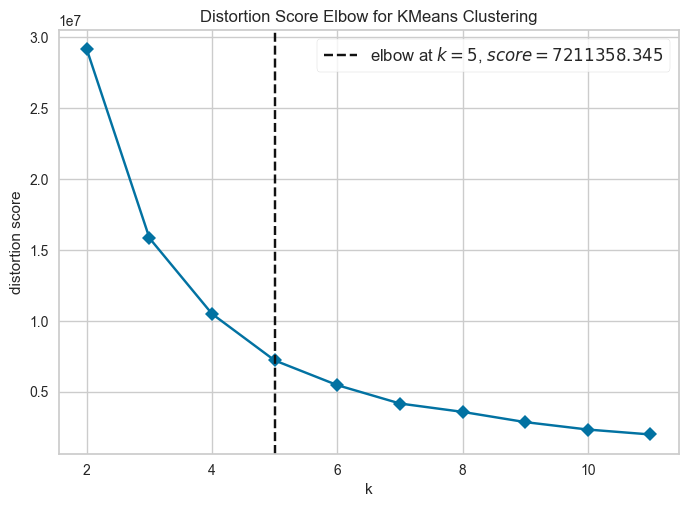

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.575


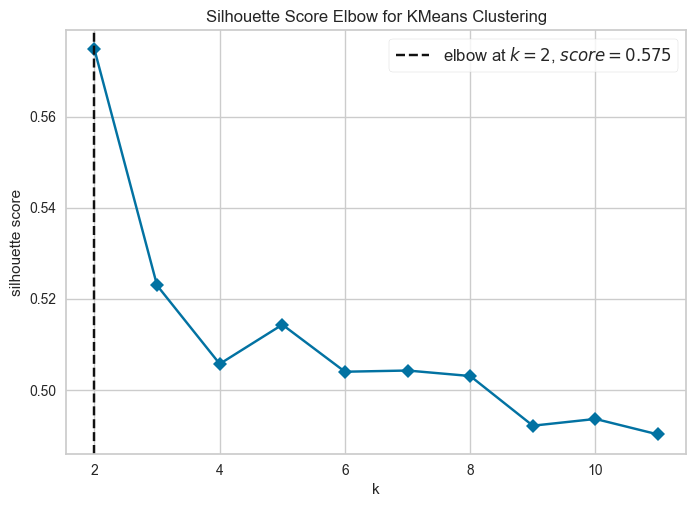

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 7  | elbow score: 69,546.952


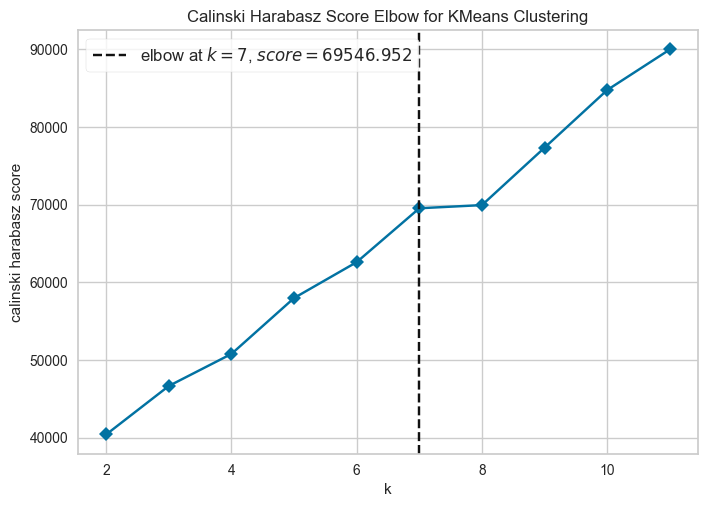

In [18]:
# elbow score plot with Yellowbrick
nK = 12    
RNDN = 42    

def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2, nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

# call elbow plot for each of 3 alternative metrics
# distortion = mean sum of squared distances to center
# silhouette = mean ratio of intra-cluster and nearest-cluster distance
# calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(X, m, model) for m in ["distortion", "silhouette", "calinski_harabasz"]]


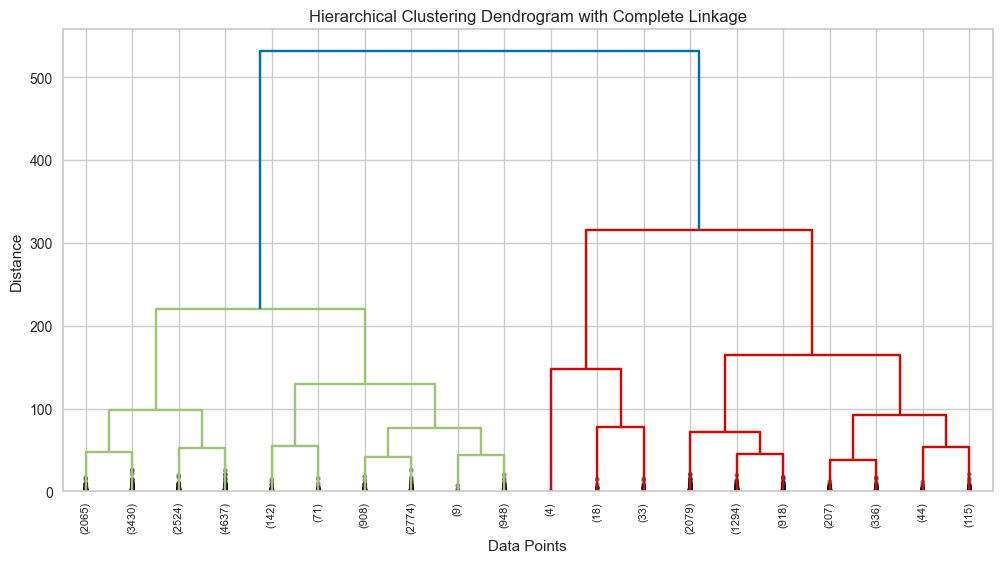

In [23]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering with complete linkage
linkage_matrix = linkage(X, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

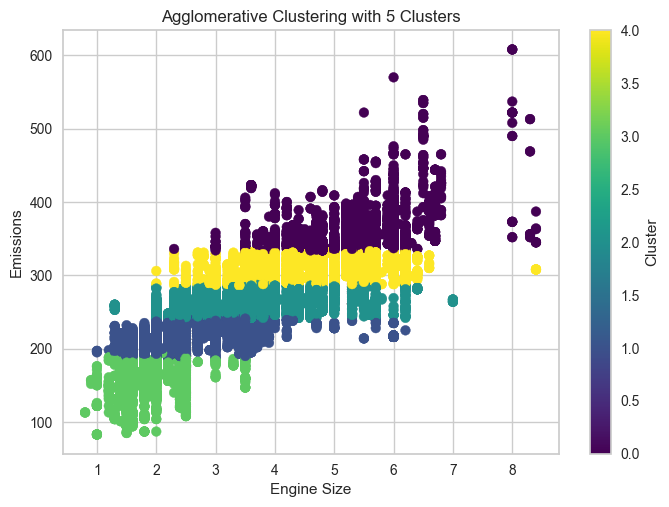

In [29]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Create an Agglomerative Clustering model
agg_cluster = AgglomerativeClustering(n_clusters=5)

# Fit the model to the data and get cluster labels
cluster_labels = agg_cluster.fit_predict(X)

# Plot the data with cluster labels
plt.scatter(X[:, 0], X[:, -1], c=cluster_labels, cmap='viridis')
plt.title(f'Agglomerative Clustering with {5} Clusters')
plt.xlabel('Engine Size')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5705698336369217
For n_clusters = 5 The average silhouette_score is : 0.513016433917016
For n_clusters = 7 The average silhouette_score is : 0.498479982515444


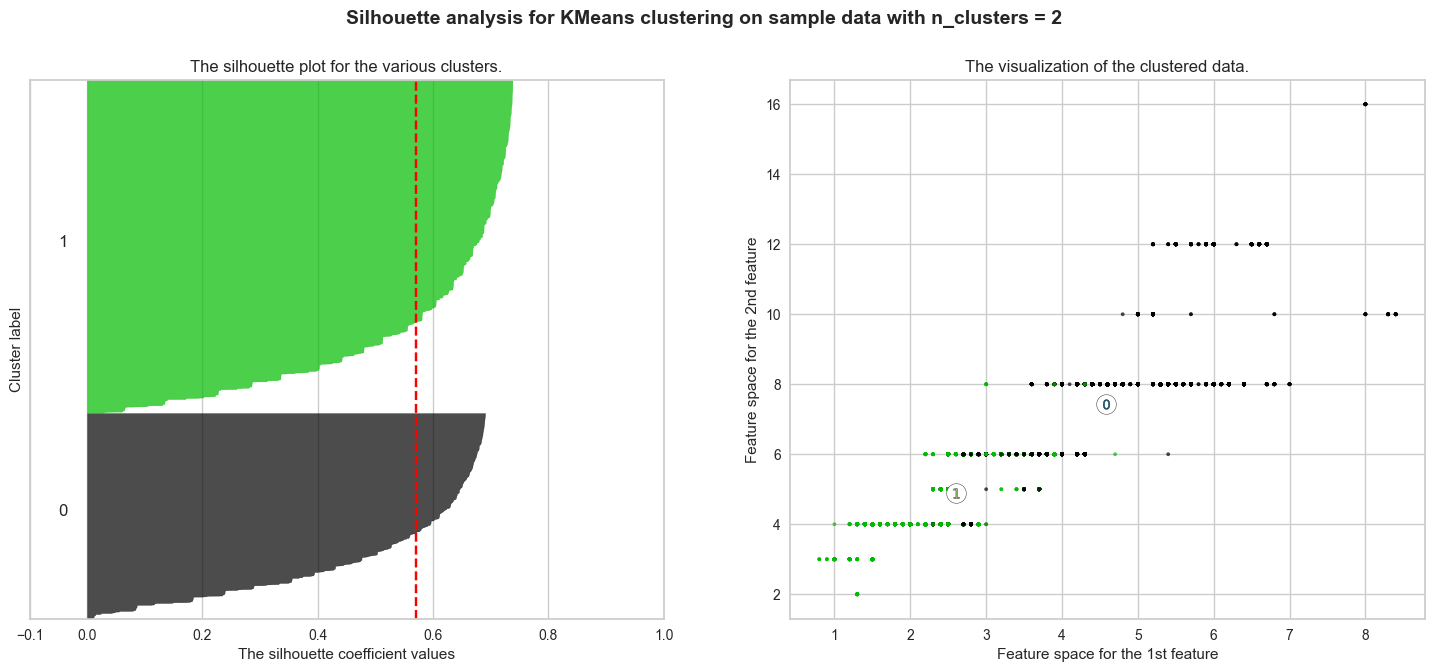

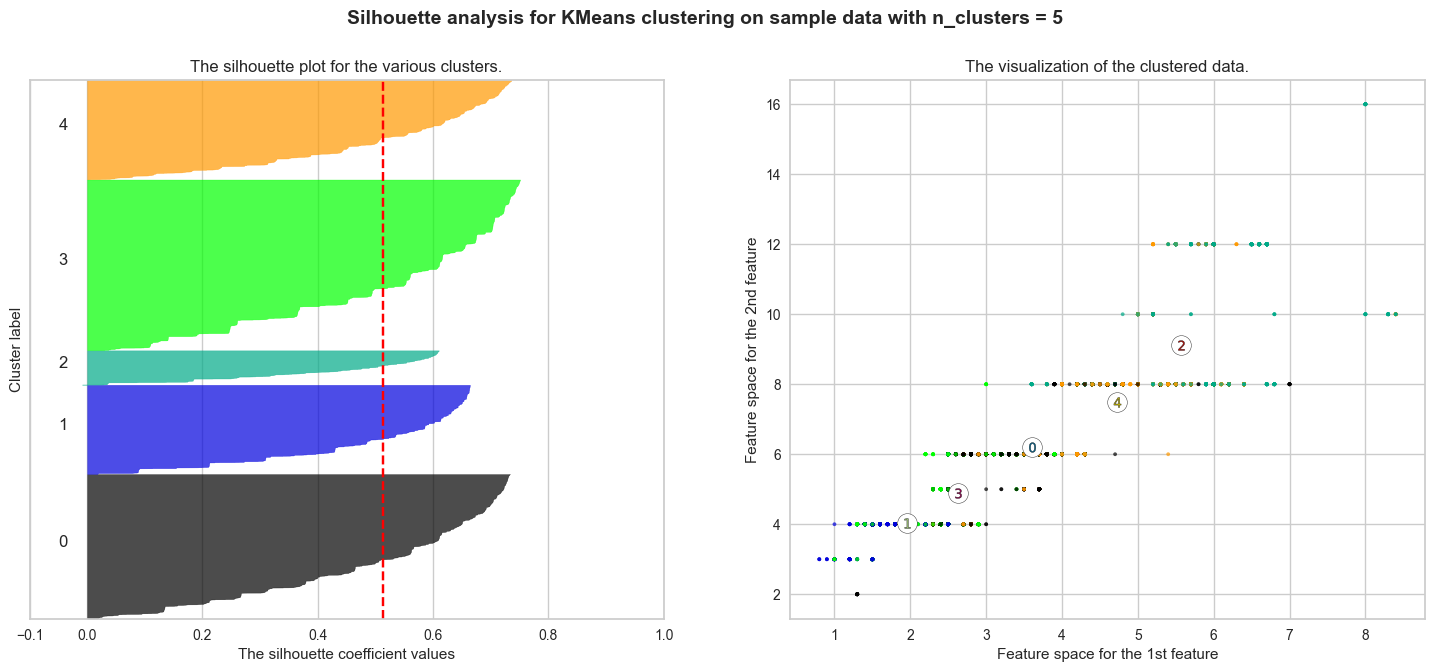

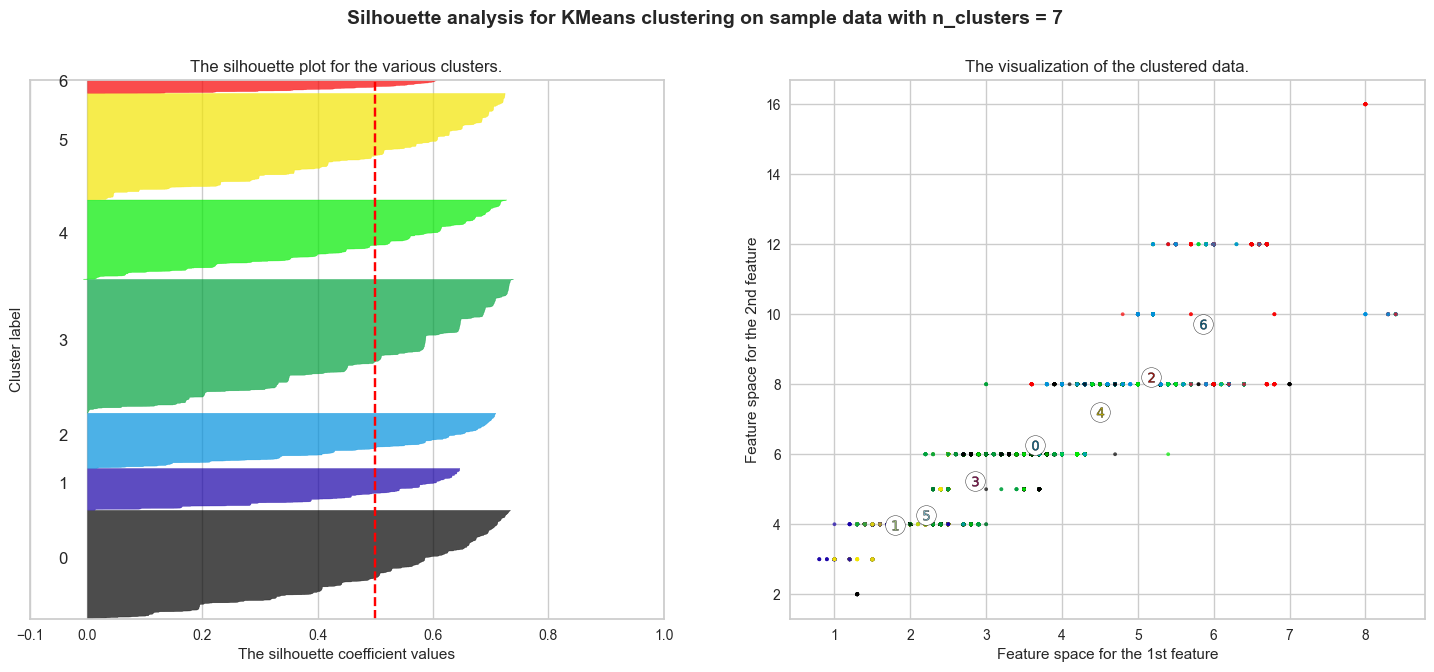

In [19]:
range_n_clusters = [2,5,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

 ## KMedias

In [22]:
km = cluster.KMeans(n_clusters=5).fit(X)
centroides = km.cluster_centers_
motor = km.predict(X)
print(motor)

[2 2 4 ... 4 0 0]


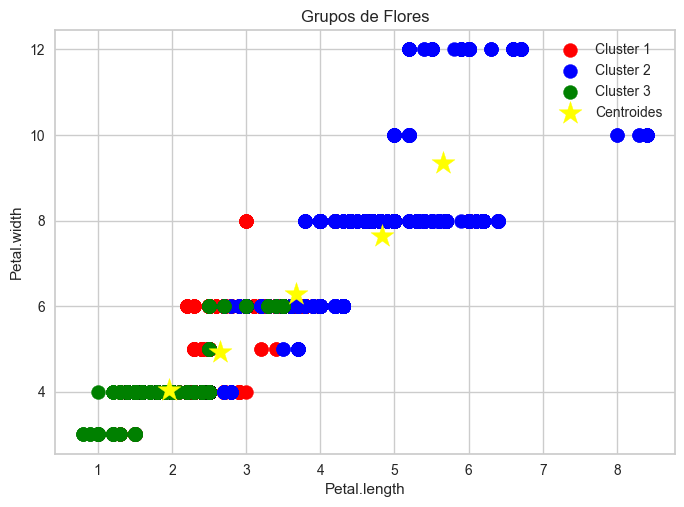

In [21]:
plt.scatter(X[motor == 0, 0], X[motor == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(X[motor == 1, 0], X[motor == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(X[motor == 2, 0], X[motor == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Grupos de Flores")
plt.xlabel("Petal.length")
plt.ylabel("Petal.width")
plt.legend()